Trying to make a FCN to predict dihedral angles. The data is from https://github.com/aqlaboratory/proteinnet casp7, text based, using only a subset of the data due to lack of computational resources. Data was preprocessed in https://github.com/githubz0r/random/blob/master/protein_fcn_preproc.ipynb 

In [63]:
import numpy as np
import torch
import imp
import re
import matplotlib.pyplot as plt
import pickle
import PeptideBuilder

Helper function to get the angles from sin and cos using atan2.

In [42]:
def back_to_angle(sin_cos_array, n_angles=3):
    angles = []
    for i in range(n_angles):
        angles_i = np.arctan2(sin_cos_array[:, i, :], sin_cos_array[:, n_angles+i, :])
        # remember that we input sin first due to atan2 definition
        angles_i = angles_i[:, np.newaxis, :]
        angles.append(angles_i)
    angles_arr = np.concatenate(angles, 1)
    return(angles_arr)
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}
pos_aa_dict = {j:i for i,j in aa_id_dict.items()}

Load files.

In [4]:
train_file = open('protein_fcn_data_test/train_data_proc', 'rb')
train_data = pickle.load(train_file)
train_file.close()

In [5]:
val_file = open('protein_fcn_data_test/val_data_proc', 'rb')
val_data = pickle.load(val_file)
val_file.close()

In [7]:
train_seqs = train_data['train_seqs']
train_coords = train_data['train_coords']
train_angles_sin_cos = train_data['train_angles_sin_cos']
train_angles = [back_to_angle(i.numpy()) for i in train_angles_sin_cos]
train_ids_remain = train_data['train_ids_after_filt']

In [8]:
val_seqs = val_data['val_seqs']
val_coords = val_data['val_coords']
val_angles_sin_cos = val_data['val_angles_sin_cos']
val_angles = [back_to_angle(i.numpy()) for i in val_angles_sin_cos]
val_ids_remain = val_data['val_ids_after_filt']

Quickly check how many proteins there are.

In [166]:
print(len(train_seqs))
print(len(val_seqs))

7964
184


We write a dataset class for the torch DataLoader. Since we only pad the minibatches (instead of everything in one tensor), we also need a custom collate function to deal with this. 

In [9]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, angles):
        self.sequences = seqs
        self.angles = angles

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return [self.sequences[idx], self.angles[idx]]

def protein_collate(batch):
    seqs = [item[0] for item in batch]
    angles = [item[1] for item in batch]
    max_len = max([x.shape[2] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[2]
        seq_padded = np.pad(seqs[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        angles_padded = np.pad(angles[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded)
        angles[i] = torch.tensor(angles_padded)
    seq_tensor = torch.cat(seqs, 0)
    angle_tensor = torch.cat(angles, 0)
    return([seq_tensor, angle_tensor])
    

In [10]:
train_dataset = proteindataset(train_seqs, train_angles_sin_cos)
val_dataset = proteindataset(val_seqs, val_angles_sin_cos)

In [11]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10,
                                          shuffle=True, num_workers=2, collate_fn=protein_collate)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2, collate_fn=protein_collate)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                         #shuffle=False, num_workers=2)

Define and run a FCN with mean squared error as loss function. Angles are transformed to sin/cos and will be backtransformed with arctan 2 after training
<br>
First half of the network does convolution and the second half does up-convolution. It also has some skip connections like the U-NET architecture (but simpler).
<br>
<br>
The proteins are encoded as $N*C*L$ where $C$ = 20 (number of amino acids) and $L$ = length.

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

kd2 = 11
pad2 = int((kd2-1)/2)
kd3 = 15
pad3 = int((kd3-1)/2)
kd4 = 21
pad4 = int((kd4-1)/2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv1d(20, 20, kernel_size=1)
        self.conv0_bn = torch.nn.BatchNorm1d(20)
        self.conv1 = nn.Conv1d(20, 15, kernel_size=kd2, padding=pad2) # down
        self.conv1_bn = torch.nn.BatchNorm1d(15)
        self.conv2 = nn.Conv1d(15, 30, kernel_size=kd3, padding=pad3) # down 
        self.conv2_bn = torch.nn.BatchNorm1d(30)
        self.conv3 = nn.Conv1d(30, 24, kernel_size=kd4, padding=pad4) # down
        self.conv3_bn = torch.nn.BatchNorm1d(24)
        self.conv4 = nn.Conv1d(24, 24, kernel_size=1)
        self.conv4_bn = torch.nn.BatchNorm1d(24)
        
        self.deconv1 = nn.ConvTranspose1d(in_channels=24, out_channels=30, kernel_size=kd4, padding=pad4) # up
        self.deconv1_bn = torch.nn.BatchNorm1d(30)
        self.conv5 = nn.Conv1d(30, 30, 1)
        self.conv5_bn = torch.nn.BatchNorm1d(30)
        
        self.deconv2 = nn.ConvTranspose1d(in_channels=60, out_channels=15, kernel_size=kd3, padding=pad3) # up
        self.deconv2_bn = torch.nn.BatchNorm1d(15)
        self.conv6 = nn.Conv1d(15, 15, 1)
        self.conv6_bn = torch.nn.BatchNorm1d(15)
        
        self.deconv3 = nn.ConvTranspose1d(in_channels=30, out_channels=15, kernel_size=kd2-1, padding=pad2) # up
        self.deconv3_bn = torch.nn.BatchNorm1d(15)
        self.conv7 = nn.Conv1d(15, 6, (1))
        self.conv7_bn = torch.nn.BatchNorm1d(6)
        self.conv8 = nn.Conv1d(6, 6, 1)
        self.conv8_bn = torch.nn.BatchNorm1d(6)
        self.conv9 = nn.Conv1d(6, 6, 1)

    def forward(self, x):
        conv0_out = F.relu(self.conv0_bn(self.conv0(x)))
        conv1_out = F.relu(self.conv1_bn(self.conv1(conv0_out)))
        conv2_out = F.relu(self.conv2_bn(self.conv2(conv1_out)))
        conv3_out = F.relu(self.conv3_bn(self.conv3(conv2_out)))
        conv4_out = F.relu(self.conv4_bn(self.conv4(conv3_out)))

        deconv1_out = F.relu(self.deconv1_bn(self.deconv1(conv4_out)))
        conv5_out = F.relu(self.conv5_bn(self.conv5(deconv1_out)))
        
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)  
        deconv2_out = F.relu(self.deconv2_bn(self.deconv2(deconv2_input)))
        conv6_out = F.relu(self.conv6_bn(self.conv6(deconv2_out)))
        
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        deconv3_out = F.relu(self.deconv3_bn(self.deconv3(deconv3_input)))
        conv7_out = F.relu(self.conv7_bn(self.conv7(deconv3_out)))
        conv8_out = F.relu(self.conv8_bn(self.conv8(conv7_out)))
        conv9_out = self.conv9(conv8_out)
        return conv9_out



Train the network.

In [13]:
net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

prints_per_epoch = 5

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None

for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, true_angles = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()
        
        # adding to running loss, we will output this at every verbose_k
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:   
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for k,j in enumerate(val_seqs):
                pred_k = net(j)
                loss_k = criterion(pred_k, val_angles_sin_cos[k]).item()
                validation_loss += loss_k/len(val_seqs)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))
            
            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'best_fcn_parameters.pt')

            running_loss = 0.0

print('Finished Training')

epoch: 0, iteration: 158] training loss: 0.15017666944167898, validation_loss: 0.22763533614899806
epoch: 0, iteration: 317] training loss: 0.10137662101747855, validation_loss: 0.2112800831420591
new best validation loss, saving..
epoch: 0, iteration: 476] training loss: 0.08956529919362669, validation_loss: 0.195476911638094
new best validation loss, saving..
epoch: 0, iteration: 635] training loss: 0.08501489270689352, validation_loss: 0.20598277773546136
epoch: 0, iteration: 794] training loss: 0.08446528399421734, validation_loss: 0.1884980772358729
new best validation loss, saving..
epoch: 1, iteration: 158] training loss: 0.08329521215655519, validation_loss: 0.1894600596683829
epoch: 1, iteration: 317] training loss: 0.0795983059460637, validation_loss: 0.18504403102333128
new best validation loss, saving..
epoch: 1, iteration: 476] training loss: 0.0820375032160642, validation_loss: 0.1816044075657492
new best validation loss, saving..
epoch: 1, iteration: 635] training loss: 

epoch: 15, iteration: 317] training loss: 0.06836568950763289, validation_loss: 0.1691655088418528
epoch: 15, iteration: 476] training loss: 0.06676226076464983, validation_loss: 0.1707597489711706
epoch: 15, iteration: 635] training loss: 0.06679426039914665, validation_loss: 0.17222634256493466
epoch: 15, iteration: 794] training loss: 0.06903236518678425, validation_loss: 0.1724866739595714
epoch: 16, iteration: 158] training loss: 0.06553156594247939, validation_loss: 0.17251424799146856
epoch: 16, iteration: 317] training loss: 0.06703649761166962, validation_loss: 0.17935186418016313
epoch: 16, iteration: 476] training loss: 0.06793102085496644, validation_loss: 0.16982755268438032
epoch: 16, iteration: 635] training loss: 0.06774806699850275, validation_loss: 0.16936151668145938
epoch: 16, iteration: 794] training loss: 0.06636685299329788, validation_loss: 0.17208653775489202
epoch: 17, iteration: 158] training loss: 0.06832002974906058, validation_loss: 0.1694000310507482
epoc

In [14]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/big_folders_docs/random/best_fcn_parameters.pt'))

net.eval()

validation_preds = [net(i) for i in val_seqs]

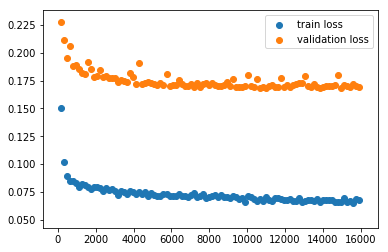

In [15]:
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

Transform the predicted values back to angles and compare.

In [16]:
validation_preds_angles = [back_to_angle(i.detach().numpy()) for i in validation_preds]

Choose a random protein as test protein

In [17]:
test_protein = val_ids_remain[49]

In [19]:
test_angles_real = val_angles[49]
test_angles_pred = validation_preds_angles[49]

Recover the amino acid sequence. Conveniently the onehot sequence has been filtered with the mask provided by the proteinnet file already, so this sequence will be filtered as well for residues missing atoms. 
We will make pdb files of the the predicted structure as well as the real structured although the coordinates for the real will be reconstructed from the angles instead of using the actual coordinates to make a more "fair" comparison, or something. These will be visualized in pymol.

In [64]:
def onehot_to_str(onehot_arr):
    '''aa*N numpy array input'''
    aas = []
    N = onehot_arr.shape[1]
    for i in range(N):
        pos = np.where(onehot_arr[:, i]>0)[0]
        aas.append(pos_aa_dict[int(pos)])
    return "".join(aas)

In [65]:
test_protein_seq = onehot_to_str(val_seqs[49].numpy()[0, :,:])

In [66]:
def make_pb_structure(seq_str, angles):
    psi = np.degrees(angles[0, :].tolist())
    omega = np.degrees(angles[1, :].tolist())
    phi = np.degrees(angles[2, :].tolist())
    structure = PeptideBuilder.make_structure(seq_str, phi, psi, omega)
    return(structure)

In [67]:
test_structure_real = make_pb_structure(test_protein_seq, test_angles_real[0, :, :])

In [69]:
test_structure_pred = make_pb_structure(test_protein_seq, test_angles_pred[0, :, :])

In [70]:
import Bio.PDB
def write_to_pdb(structure, prot_id, identifier):
    out = Bio.PDB.PDBIO()
    out.set_structure(structure)
    out.save(prot_id + identifier + ".pdb")

In [71]:
write_to_pdb(test_structure_real, test_protein, '_real_v8')
write_to_pdb(test_structure_pred, test_protein, '_pred_v8')

We can open the saved pdb files in pymol, align them and save the image. Cyan = true, green = predicted.

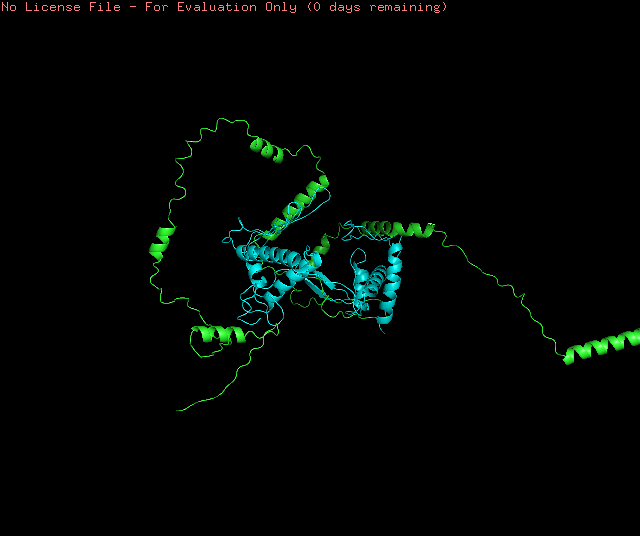

In [73]:
from IPython.display import Image 
im = Image(filename="/Users/Deathvoodoo/big_folders_docs/random/protein_alignment_v8.png")
display(im)

Not quite alphafold tier.
<br>
<br>
Checking distribution of angles for the test protein.

In [74]:
print(test_angles_pred.shape)
print(test_angles_real.shape)

(1, 3, 242)
(1, 3, 242)


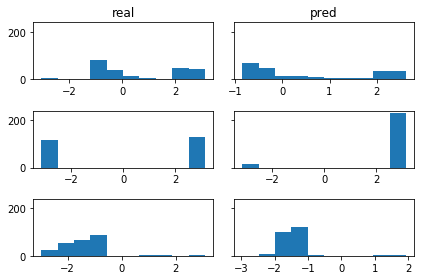

In [167]:
fig, axs = plt.subplots(3, 2, sharey=True, tight_layout=True)
#n_bins=20
labels = ['real', 'pred']
axs[0, 0].hist(test_angles_real[0, 0,:])
axs[0, 0].set_title('real')
axs[0, 1].hist(test_angles_pred[0, 0,:])
axs[0, 1].set_title('pred')
axs[1, 0].hist(test_angles_real[0, 1,:])
axs[1, 1].hist(test_angles_pred[0, 1,:])
axs[2, 0].hist(test_angles_real[0, 2,:])
axs[2, 1].hist(test_angles_pred[0, 2,:])
plt.show()

In [76]:
def make_coord_array(pdbstructure):
    '''turn coordinates into an array to calculate rmsd'''
    structure = pdbstructure
    model = structure[0]
    chain = model['A']

    atom_coords = []
    for atom in chain.get_atoms():
        if atom.get_id()=='N':
            atom_coords.append(atom.get_coord())
        elif atom.get_id()=='CA':
            atom_coords.append(atom.get_coord())
        elif atom.get_id()=='C':
            atom_coords.append(atom.get_coord())
    atom_coords = np.array(atom_coords).T
    return atom_coords
    

In [134]:
test_structure_coords_pred = make_coord_array(test_structure_pred)
test_structure_coords_real = make_coord_array(test_structure_real)

Check RMSD between predicted and 'real' coordinates.

In [157]:
from numpy.linalg import svd, det
def rmsd_calculator(x, y):
    ''' rmsd code from first year of master degree, code might suck. Arrays must be 3*n '''
    n = x.shape[1]
    centered_x = (x.T - np.mean(x, 1)).T # centering the coordinates
    centered_y = (y.T - np.mean(y, 1)).T
    R = centered_y @ centered_x.T
    V, S, WT = svd(R) # singular value decomposition
    U = WT.T@V.T
    Z = np.array([[1,0,0],[0,1,0],[0,0,-1]]) # matrix for reflection catch
    if det(U) < 0: # reflection catch
        U = WT.T @ Z @ V.T
        S[2] = -S[2]
    
    E_0 = np.sum(centered_x**2+centered_y**2)
    rmsd = np.sqrt(1/n*(E_0 - 2*np.sum(S)))
    return(rmsd)


print(rmsd_calculator(test_structure_coords_real, test_structure_coords_pred))

38.98346888462761


Check RMSD between real coordinates and 'real' coordinates reconstructed from angles.

In [158]:
print(rmsd_calculator(test_structure_coords_real, val_coords[49]))

1797.2509027557796


Judging by that latter RMSD something has gone wrong somewhere as they should be much more similar. However, the main objective was to demonstrate pytorch.